In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [2]:
dataframe = pd.read_csv('../data/metric_date.csv', sep=',')
dataframe = dataframe.iloc[:,0:4]
indexNames = dataframe[ dataframe['metric_id'] == dataframe.iloc[0,0] ].index
# indexNames = dataframe[ dataframe['metric_id'] == '' ].index
dataframe = dataframe.iloc[indexNames].sort_values(by='timestamp', ascending=True).loc[:,['value']]

dataset = dataframe.values
dataset = dataset.astype('float32')

In [3]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [4]:
# reshape into X=t and Y=t+1
look_back = 30
x_train, y_train = create_dataset(train, look_back)
x_valid, y_valid = create_dataset(test, look_back)

In [5]:
def model_dnn(look_back):
    model=Sequential()
    model.add(Dense(units=16, input_dim=look_back, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    
model = model_dnn(look_back)
history = model.fit(x_train,y_train, epochs=100, batch_size=30, verbose=0, validation_data=(x_valid,y_valid), shuffle=False)

Train Root Mean Squared Error(RMSE): 3.64; Train Mean Absolute Error(MAE) : 2.75 
Test Root Mean Squared Error(RMSE): 3.45; Test Mean Absolute Error(MAE) : 2.53 


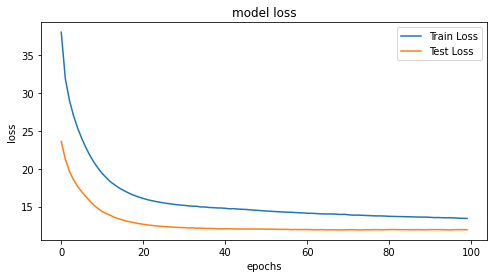

In [6]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' % (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' % (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [7]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(18,6))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Metric Value', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

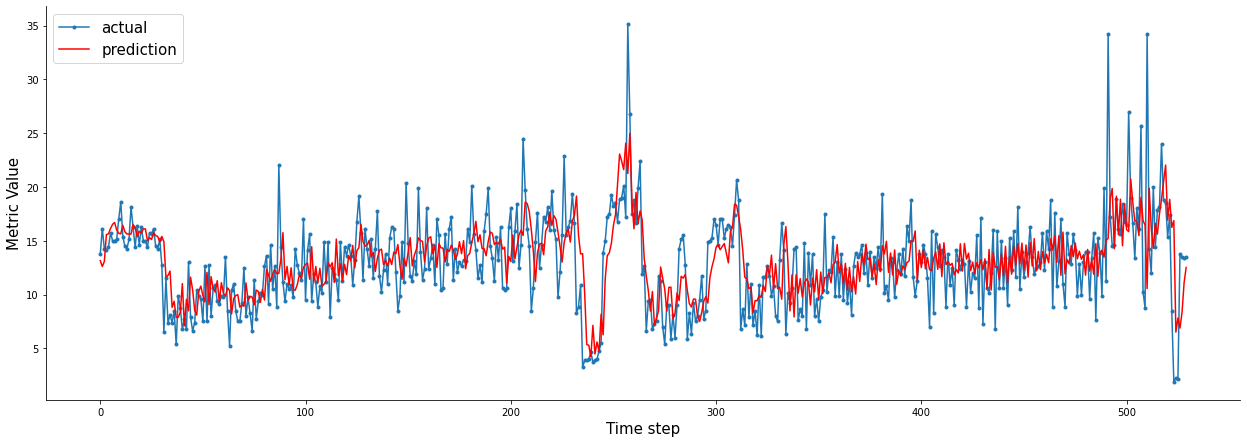

In [8]:
pred_valid = model.predict(x_valid)
pred_train = model.predict(x_train)
prediction_plot(y_valid, pred_valid)

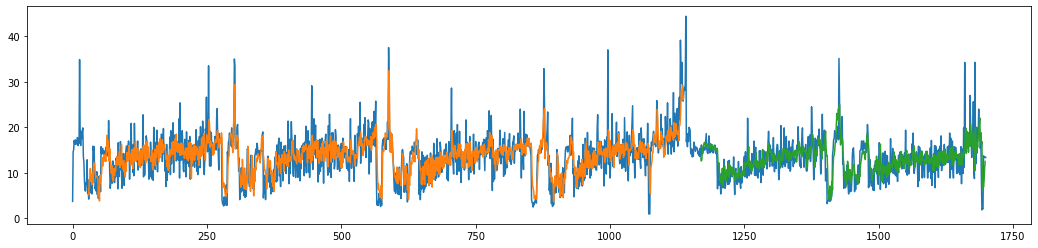

In [9]:
# shift train predictions for plotting
plt.figure(figsize=(18,4))
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(pred_train)+look_back, :] = pred_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(pred_train)+(look_back*2)+1:len(dataset)-1, :] = pred_valid
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()